# Neural Style Transfer Exp:1



In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!pip install -q fastai==0.7.0 torchtext==0.2.3

In [0]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage

In [0]:
PATH = Path('data/imagenet')
PATH_IMAGES = PATH/'images'
PATH_STYLE = PATH/'style'

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [0]:
class NeuralStyleTransfer(object):
    
    def __init__(self,base_model,sz,layers_to_use=None):
        self.base_model = base_model
        self.sz = sz
        self.model = to_gpu(base_model(True)).eval()
        set_trainable(self.model, False)
        self.block_ends = [i-1 for i,o in enumerate(children(self.model))
              if isinstance(o,nn.MaxPool2d)]
        self.trn_tfms,self.val_tfms = tfms_from_model(self.base_model, self.sz)
        
        
    def get_opt(self,img):
        opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
        opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
        opt_img_v = V(self.val_tfms(opt_img/2)[None], requires_grad=True)
        return opt_img_v, optim.LBFGS([opt_img_v])
    
    def step(self,loss_fn):
        self.optimizer.zero_grad()
        loss = loss_fn(self.opt_img_v)
        loss.backward()
        self.n_iter+=1
        if self.print_losses:
            if self.n_iter%self.show_iter==0: print(f'Iteration: {self.n_iter}, loss: {loss.data[0]}')
        return loss

    def scale_match(self, src, targ):
        h,w,_ = src.shape
        sh,sw,_ = targ.shape
        rat = max(h/sh,w/sw); rat
        res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
        return res[:h,:w]
    
    def gram(self,input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

    def gram_mse_loss(self,input, target):
        return F.mse_loss(self.gram(input), self.gram(target))
    
    def comb_loss(self,x):
        self.model(self.opt_img_v)
        outs = [V(o.features) for o in self.sfs]
        losses = [self.gram_mse_loss(o, s) for o,s in zip(outs, self.targ_styles)]
        cnt_loss   = F.mse_loss(outs[self.content_layer_to_use], self.targ_vs[self.content_layer_to_use])*1000000
        if self.style_loss_multipliers is None:
            style_loss = sum(losses)
        else:
            style_loss = sum([a*b for a,b in zip(losses,self.style_loss_multipliers)])
        return self.content_loss_proportion*cnt_loss + self.style_loss_proportion*style_loss

    def generate(self,content_image,style_img=None,
                 layers_to_use=None, content_layer_to_use=3,
                 content_loss_proportion=1.,
                 style_loss_proportion=1.,
                 style_loss_multipliers=None,
                 max_iter=500,show_iter=300,
                 print_losses=False):
        
        self.max_iter = max_iter
        self.show_iter = show_iter
        
        self.content_loss_proportion = content_loss_proportion
        self.style_loss_proportion = style_loss_proportion
        self.style_loss_multipliers = style_loss_multipliers
        self.print_losses = print_losses
        
        if self.style_loss_multipliers is not None:
            assert len(self.style_loss_multipliers) == len(self.block_ends)
        if layers_to_use is None:
            self.sfs = [SaveFeatures(children(self.model)[idx]) for idx in self.block_ends]
        else:
            self.sfs = [SaveFeatures(children(self.model)[idx]) for idx in [self.block_ends[i] for i in layers_to_use]]
        
        self.content_layer_to_use = content_layer_to_use

        img_tfm = self.val_tfms(content_image)
        self.opt_img_v, self.optimizer = self.get_opt(content_image)
        self.model(VV(img_tfm[None]))
        self.targ_vs = [V(o.features.clone()) for o in self.sfs]

        self.style_tfm = self.val_tfms(style_img)
        self.model(VV(self.style_tfm[None]))
        self.targ_styles = [V(o.features.clone()) for o in self.sfs]
        
        self.n_iter=0
#         print(f'Generating...\n')

        while self.n_iter <= self.max_iter: self.optimizer.step(partial(self.step,self.comb_loss))
        for sf in self.sfs: sf.close()
        return self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0]

In [0]:
!mkdir -p {PATH_STYLE}

In [0]:
# !wget -qq https://raw.githubusercontent.com/jeffxtang/fast-style-transfer/master/images/starry_night.jpg -P {PATH}/'style'/ 
style_fn = PATH/'style'/'starry_night.jpg'

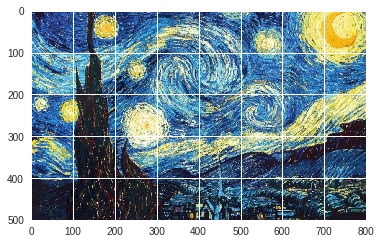

In [0]:
starry_night_img = open_image(style_fn)
plt.imshow(starry_night_img);

In [0]:
from math import ceil

In [0]:
t1 = NeuralStyleTransfer(vgg16,350)

Reconstructions using content from different layers.

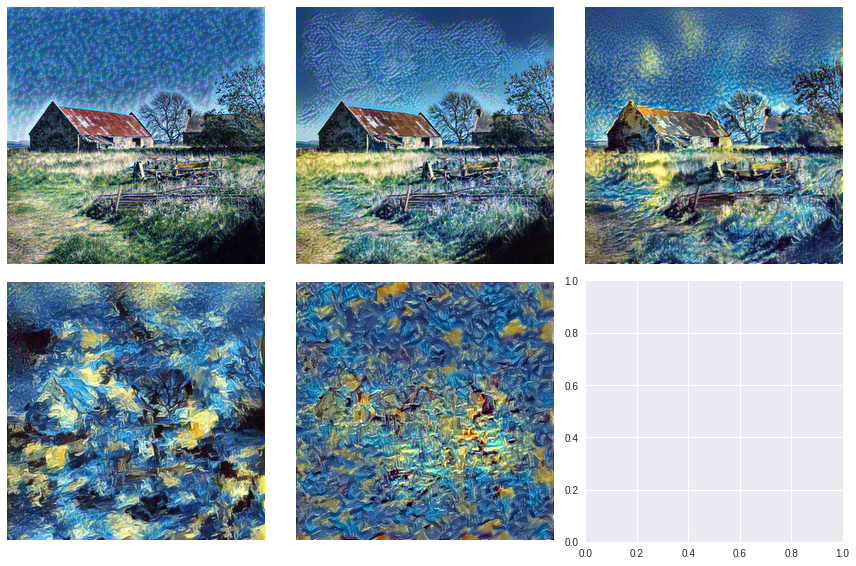

In [61]:
img_fn = PATH_IMAGES/'img2.jpg'
img = open_image(img_fn)

layers_to_use = [0,1,2,3,4]

n_cols = 3
n_rows = ceil(len(layers_to_use)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

for i,ax in enumerate(axes.flat):
    if i==len(layers_to_use):
        break
    
        
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    gen4 = t1.generate(img,style_img,
                   content_layer_to_use=layers_to_use[i],
                   style_loss_proportion=1.,
                   style_loss_multipliers=None,
                   max_iter=800)
    x = np.clip(gen4, 0, 1)
    ax.imshow(x,interpolation='lanczos')
plt.tight_layout()       
plt.show()

Reconstructions using content from 3rd chosen layer, and different weightages for style.

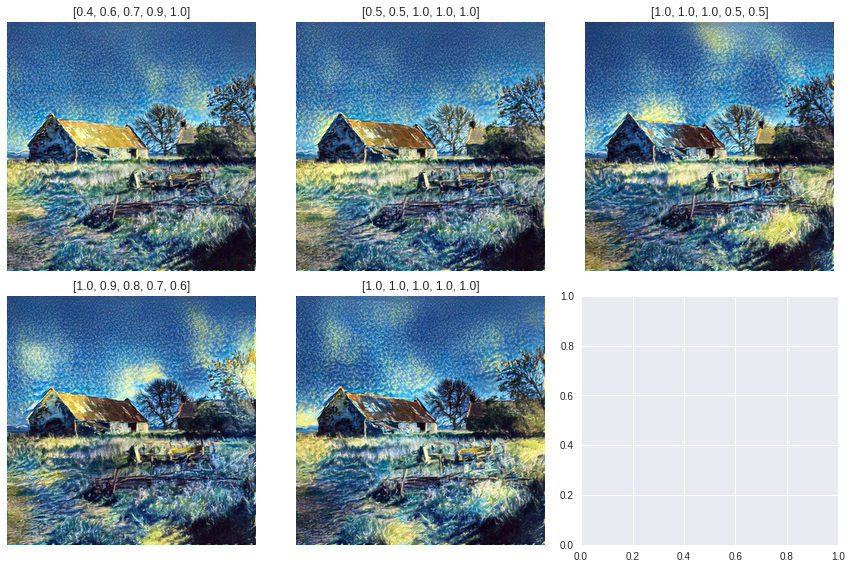

In [25]:
astyle_loss_multipliers_list = [[0.4,0.6,0.7,0.9,1.0],
                          [0.5,0.5,1.0,1.0,1.0],
                          [1.,1.,1.0,0.5,0.5],
                          [1.,0.9,0.8,0.7,0.6],
                         [1.,1.,1.,1.,1.]
                         ]

n_cols = 3
n_rows = ceil(len(layers_to_use)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

for i,ax in enumerate(axes.flat):
    if i==len(style_loss_multipliers_list):
        break
        
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{style_loss_multipliers_list[i]}')

    gen4 = t1.generate(img,style_img,
                   content_layer_to_use=2,
                   style_loss_proportion=1.,
                   style_loss_multipliers=style_loss_multipliers_list[i],
                   max_iter=1500)
    x = np.clip(gen4, 0, 1)
    ax.imshow(x,interpolation='lanczos')
plt.tight_layout()       
plt.show()

In [0]:
paintings = {
    "van_gogh_self_portrait":"https://cdn.shopify.com/s/files/1/0223/4033/products/V495_bfc78f33-3b1a-40ec-bd64-f85c4ec05fa4_1024x1024.jpg",
    "kanagawa_wave":"https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/The_Great_Wave_off_Kanagawa.jpg/1024px-The_Great_Wave_off_Kanagawa.jpg",
    "fox_franz_marc":"http://www.franzmarc.com/Fox%20Franz%20Marc.jpg",
    "the_scream":"https://images-na.ssl-images-amazon.com/images/I/81Z7qbHAjDL._SY679_.jpg",
    "girl_with_pearl":"https://cdn.britannica.com/33/194733-050-4CF75F31.jpg",
    "mona_lisa":"https://cdn.britannica.com/24/189624-050-F3C5BAA9.jpg"
}

In [0]:
!mkdir -p {PATH_STYLE}

In [52]:
for painting in paintings:
    print(f'!wget -qq "{paintings[painting]}" -O {PATH_STYLE}/{painting}.jpg')
#     !wget -qq "{paintings[painting]}" -O {PATH_STYLE}/{painting}.jpg

!wget -qq "https://cdn.shopify.com/s/files/1/0223/4033/products/V495_bfc78f33-3b1a-40ec-bd64-f85c4ec05fa4_1024x1024.jpg" -O data/imagenet/style/van_gogh_self_portrait.jpg
!wget -qq "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/The_Great_Wave_off_Kanagawa.jpg/1024px-The_Great_Wave_off_Kanagawa.jpg" -O data/imagenet/style/kanagawa_wave.jpg
!wget -qq "http://www.franzmarc.com/Fox%20Franz%20Marc.jpg" -O data/imagenet/style/fox_franz_marc.jpg
!wget -qq "https://images-na.ssl-images-amazon.com/images/I/81Z7qbHAjDL._SY679_.jpg" -O data/imagenet/style/the_scream.jpg
!wget -qq "https://cdn.britannica.com/33/194733-050-4CF75F31.jpg" -O data/imagenet/style/girl_with_pearl.jpg
!wget -qq "https://cdn.britannica.com/24/189624-050-F3C5BAA9.jpg" -O data/imagenet/style/mona_lisa.jpg


In [0]:
style_paintings = []
paintings_names = []

for painting in paintings:
    try:
        style_paintings.append(open_image(f'{PATH_STYLE}/{painting}.jpg'))
        paintings_names.append(painting)
    except Exception as e:
        print(str(e))

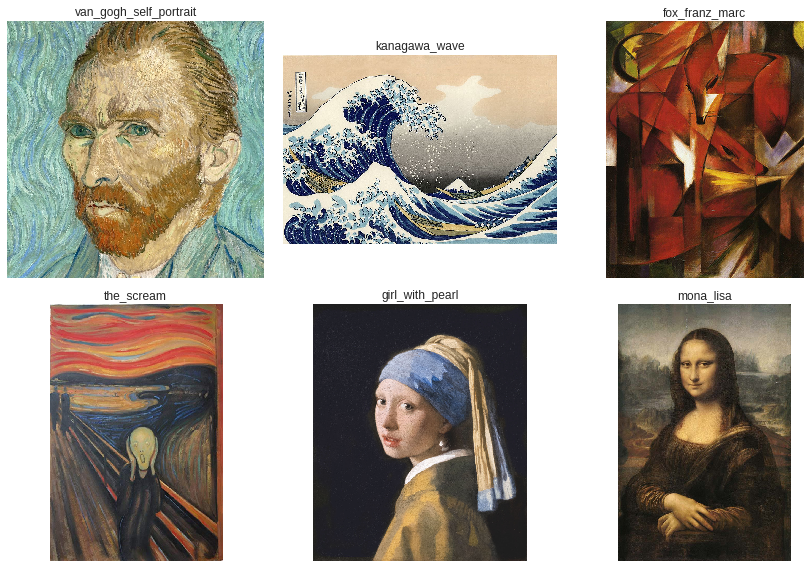

In [57]:
n_cols = 3
n_rows = ceil(len(style_paintings)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

for i,ax in enumerate(axes.flat):
        
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{paintings_names[i]}')

    ax.imshow(style_paintings[i])
plt.tight_layout()       
plt.show()

Reconstructing from these paintings.

Generating 1: van_gogh_self_portrait...
Generating 2: kanagawa_wave...
Generating 3: fox_franz_marc...
Generating 4: the_scream...
Generating 5: girl_with_pearl...
Generating 6: mona_lisa...


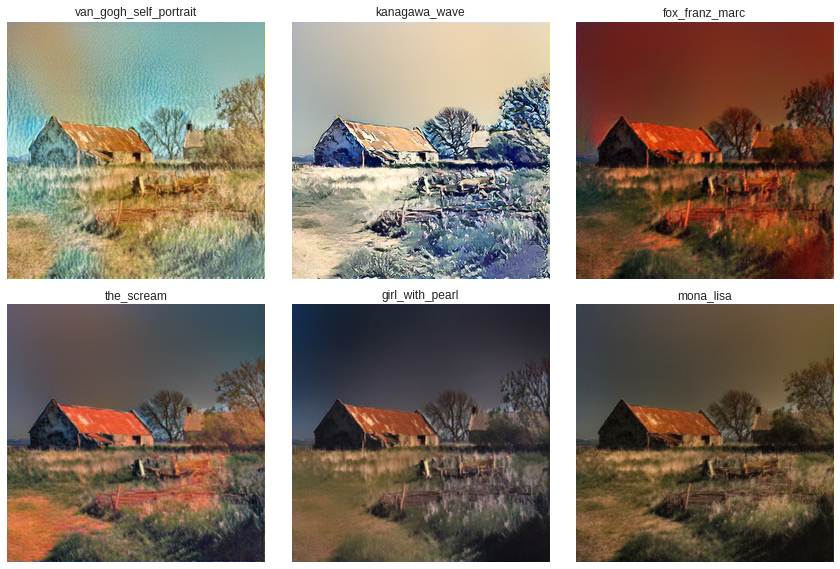

In [58]:
n_cols = 3
n_rows = ceil(len(style_paintings)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

for i,ax in enumerate(axes.flat):
    if i==len(style_paintings):
        break
        
    print(f'Generating {i+1}: {paintings_names[i]}...')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{paintings_names[i]}')

    gen4 = t1.generate(img,style_paintings[i],
                   content_layer_to_use=2,
                   style_loss_proportion=1.,
                   style_loss_multipliers=[0.5,0.5,1.0,1.0,1.0],
                   max_iter=1500)
    x = np.clip(gen4, 0, 1)
    ax.imshow(x,interpolation='lanczos')
plt.tight_layout()       
plt.show()

In [0]:
paintings_2 = {
    "liberty_leading_people":"https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Eug%C3%A8ne_Delacroix_-_Le_28_Juillet._La_Libert%C3%A9_guidant_le_peuple.jpg/1200px-Eug%C3%A8ne_Delacroix_-_Le_28_Juillet._La_Libert%C3%A9_guidant_le_peuple.jpg",
    "old_guitarist":"https://upload.wikimedia.org/wikipedia/en/thumb/b/bc/Old_guitarist_chicago.jpg/1200px-Old_guitarist_chicago.jpg",
    "cafe_terrace":"https://www.vincentvangogh.org/images/paintings/cafe-terrace-at-night.jpg",
    "impression_sunrise":"https://www.gallerylafayette.com/neu/wp-content/uploads/2014/10/impression-sunrise.jpg",
    "irises":"https://www.vincentvangogh.org/images/paintings/irises.jpg",
    "the_night_cafe":"http://cdn.artobserved.com/2009/03/vincent-van-gogh-the-night-cafe-1888-via-artstor-collections.jpg",
}